### 1. Setup.

In [1]:
from scipy import ndimage, misc
from medpy.io import load
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import pickle
import os

### 2. Read the images and preprocess. 
#### Save the train and test sets into a pickle file such that we could load it later without run the preprocessing code again.

In [ ]:
def read_img(filepath):
    # Read volume from mha file, and only keep one slice
    img_data, img_header = load(filepath)
    idx = int(img_data.shape[2]/2) + 5
    return img_data[:,:,idx]

def normalize(vol):
    # Threshold between 400 and -1000 is commonly used to normalize CT scans
    max = 400
    min = -1000
    vol[vol > max] = max
    vol[vol < min] = min
    vol = (vol - min) / (max - min)
    vol = vol.astype("float32")
    return vol

def resize(img):
    # Set the desired size
    desired_width = 256
    desired_height = 256
    # Compute size factor
    width = img.shape[0] / desired_width
    height = img.shape[1] / desired_height
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor), order=1)
    return img

def process_scan(path):
    # Read CT scan
    volume = read_img(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height
    volume = resize(volume)
    return volume

In [ ]:
filename = 'C:/Users/ssila/Documents/DL_Project/Dataset/metadata/selected_data.csv'
# filename = 'C:/Users/ssila/Documents/DL_Project/Dataset/metadata/reference.csv'
fields = []
rows = []
with open(filename, 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    fields = next(csvreader)
    for row in csvreader:
        rows.append(row)
print('Field names are: ', fields)
print('Here is an example: ', rows[0])
split=train_test_split(rows, test_size=0.25, shuffle=True)
trainList=split[0]
testList=split[1]
print('Training set size: ',len(trainList))
print('Testing set size: ', len(testList))

In [ ]:
# Get path for both train set and test set
train_path = []
for id in trainList:
    filepath = f'C:/Users/ssila/Documents/DL_Project/Dataset/data/mha/{id[0]}.mha'
    train_path.append(filepath)
test_path = []
for id in testList:
    filepath = f'C:/Users/ssila/Documents/DL_Project/Dataset/data/mha/{id[0]}.mha'
    test_path.append(filepath)
# Load dataset 
print('==========> Begin to load train datasets!')
x_train = np.array([process_scan(path) for path in train_path])
print('==========> Train datasets loaded! Begin to load test datasets!')
x_test = np.array([process_scan(path) for path in test_path])
print('==========> Test datasets loaded!')
print('==========> The size of train and test set are %d and %d.' % (x_train.shape[0], x_test.shape[0]))

In [ ]:
# Load y label
y_train = np.array([int(id[1]) + int(id[2]) for id in trainList])
y_test = np.array([int(id[1]) + int(id[2]) for id in testList])
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('Three categories: Non-covid, Covid-not-severe, Covid-severe.')

In [ ]:
# Save the dataset as pkl file since it may take a while to load from mha files
save_path = './'
with open(os.path.join(save_path,"train_DL.pickle"), "wb") as f:
    pickle.dump((x_train, y_train),f)
with open(os.path.join(save_path,"test_DL.pickle"), "wb") as f:
    pickle.dump((x_test, y_test),f)

In [2]:
save_path = './'
with open(os.path.join(save_path, "train_DL.pickle"), "rb") as f:
    (x_train, y_train) = pickle.load(f)
with open(os.path.join(save_path, "test_DL.pickle"), "rb") as f:
    (x_test, y_test) = pickle.load(f)
print('Load dataset from pickles, print out the shape of datasets: ')
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

Load dataset from pickles, print out the shape of datasets: 
(675, 256, 256)
(225, 256, 256)
(675, 3)
(225, 3)


### 3. Print some images as well as labels.

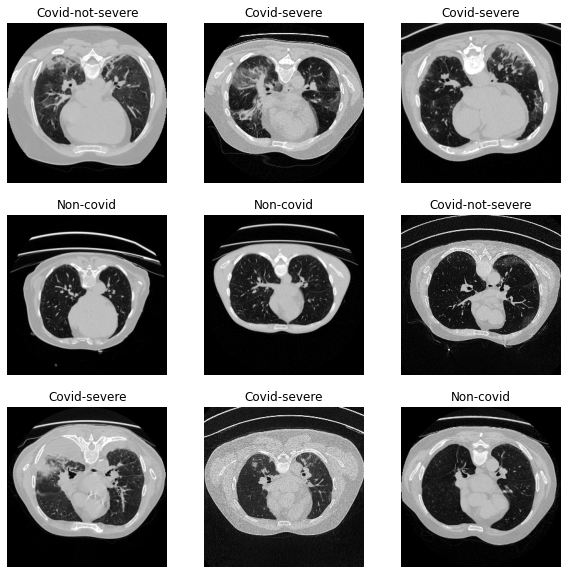

In [3]:
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[400 + i], cmap='gray')
    if y_train[400 + i][0] == 1:
        label = 'Non-covid'
    if y_train[400 + i][1] == 1:
        label = 'Covid-not-severe'
    if y_train[400 + i][2] == 1:
        label = 'Covid-severe'
    plt.title(label)
    plt.axis("off")

### 4. Data augmentation.

In [4]:
# Check GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# To perform convolution, add one dimension of size 1
@tf.function
def rotate(volume):
    def scipy_rotate(volume):
        # rotate the volume randomly
        angles = [-60, -45, -30, -15, 15, 30, 45, 60]
        angle = random.choice(angles)
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume
    volume_rotate = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return volume_rotate

def train_preprocessing(volume, label):
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=2)
    return volume, label

def test_preprocessing(volume, label):
    # Only add a dimension to test data without rotation
    volume = tf.expand_dims(volume, axis=2)
    return volume, label

In [6]:
# Get data loaders and augmented datasets
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 10
train_set = (train_loader.shuffle(len(x_train)).map(train_preprocessing).batch(batch_size).prefetch(2))
test_set = (test_loader.shuffle(len(x_test)).map(test_preprocessing).batch(batch_size).prefetch(2))

Dimension of the CT scan is: (256, 256, 1)


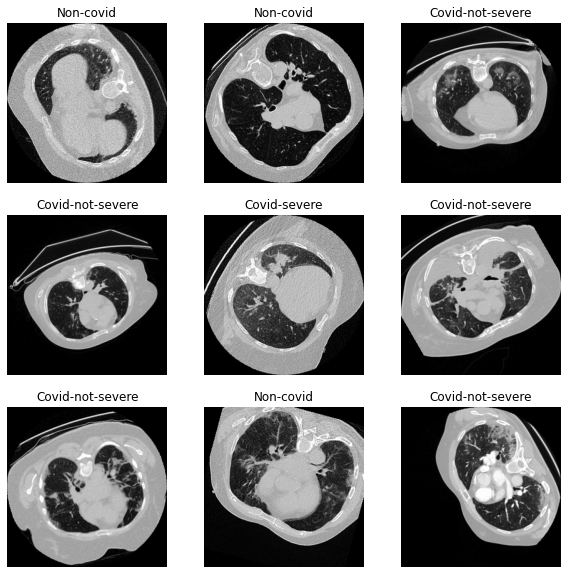

In [7]:
# Visualization after augmentation
data = train_set.take(1)
images, labels = list(data)[0]
images = images.numpy()
# print(images.shape)
labels = labels.numpy()
print("Dimension of the CT scan is:", images[0].shape)
    
def get_img(idx):
    image = images[idx]
    label = labels[idx]
    if label[0] == 1:
        tag = 'Non-covid'
    if label[1] == 1:
        tag = 'Covid-not-severe'
    if label[2] == 1:
        tag = 'Covid-severe'
    return image, tag

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image, tag = get_img(i)
    plt.imshow(np.squeeze(image[:, :]), cmap="gray")
    plt.title(tag)
    plt.axis("off")

### 5. Get model of NN.

In [8]:
def get_model(width=256, height=256):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, 1))

    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=3, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="cnn")
    return model


# Build model.
model = get_model(width=256, height=256)
model.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 16)       0       

### 6. Train the NN.

In [9]:
# Compile model.
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=["acc"])

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "image_3class_classification.h5",
    monitor='val_acc',
    mode='max',
    save_best_only=True)
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc",
#                                                   patience=15)

# Train the model
epochs = 60
model.fit(train_set, validation_data=test_set, epochs=epochs, shuffle=True,
          verbose=2, callbacks=[checkpoint_cb])

Epoch 1/60
68/68 - 8s - loss: 1.0756 - acc: 0.4104 - val_loss: 1.1576 - val_acc: 0.3333 - 8s/epoch - 111ms/step
Epoch 2/60
68/68 - 4s - loss: 1.0683 - acc: 0.4237 - val_loss: 1.2369 - val_acc: 0.3333 - 4s/epoch - 57ms/step
Epoch 3/60
68/68 - 4s - loss: 1.0533 - acc: 0.4563 - val_loss: 1.6028 - val_acc: 0.3333 - 4s/epoch - 58ms/step
Epoch 4/60
68/68 - 4s - loss: 1.0571 - acc: 0.4607 - val_loss: 1.5921 - val_acc: 0.3333 - 4s/epoch - 57ms/step
Epoch 5/60
68/68 - 4s - loss: 1.0305 - acc: 0.4711 - val_loss: 1.6567 - val_acc: 0.3333 - 4s/epoch - 57ms/step
Epoch 6/60
68/68 - 4s - loss: 1.0391 - acc: 0.4607 - val_loss: 1.2970 - val_acc: 0.3333 - 4s/epoch - 59ms/step
Epoch 7/60
68/68 - 4s - loss: 1.0457 - acc: 0.4607 - val_loss: 1.2330 - val_acc: 0.3333 - 4s/epoch - 57ms/step
Epoch 8/60
68/68 - 4s - loss: 1.0328 - acc: 0.4696 - val_loss: 1.0503 - val_acc: 0.4400 - 4s/epoch - 60ms/step
Epoch 9/60
68/68 - 4s - loss: 1.0309 - acc: 0.4948 - val_loss: 1.2061 - val_acc: 0.3644 - 4s/epoch - 60ms/step


### 7. Results.

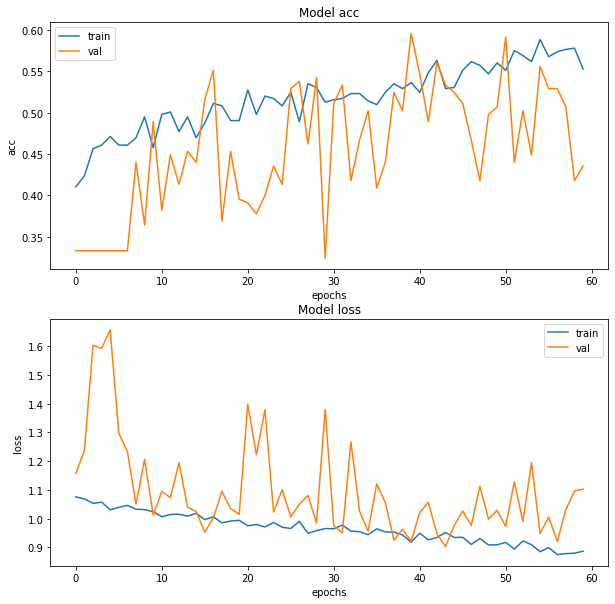

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
plt.savefig("DLresult3.png")

In [11]:
max_acc_index = model.history.history['val_acc'].index(max(model.history.history['val_acc']))
print("Max Training Accuracy: ", model.history.history['acc'][max_acc_index])
print("Max Validation Accuracy: ", model.history.history['val_acc'][max_acc_index])

Max Training Accuracy:  0.5362963080406189
Max Validation Accuracy:  0.5955555438995361


In [12]:
model.load_weights("image_3class_classification.h5")

for i in range(9):
    prediction = model.predict(np.expand_dims(x_test[125 + i], axis=0))[0]
    print('Ground truth is: ', y_test[125 + i])

    class_names = ["Non-covid", "Covid-not-severe", "Covid-severe"]
    for score, name in zip(prediction, class_names):
        print(
            "This model is %.5f percent confident that CT scan is %s"
            % ((100 * score), name))

Ground truth is:  [0. 1. 0.]
This model is 33.59486 percent confident that CT scan is Non-covid
This model is 46.70258 percent confident that CT scan is Covid-not-severe
This model is 19.70256 percent confident that CT scan is Covid-severe
Ground truth is:  [0. 0. 1.]
This model is 28.86570 percent confident that CT scan is Non-covid
This model is 47.16140 percent confident that CT scan is Covid-not-severe
This model is 23.97289 percent confident that CT scan is Covid-severe
Ground truth is:  [0. 0. 1.]
This model is 20.35744 percent confident that CT scan is Non-covid
This model is 19.65953 percent confident that CT scan is Covid-not-severe
This model is 59.98303 percent confident that CT scan is Covid-severe
Ground truth is:  [0. 0. 1.]
This model is 33.38294 percent confident that CT scan is Non-covid
This model is 8.54706 percent confident that CT scan is Covid-not-severe
This model is 58.07000 percent confident that CT scan is Covid-severe
Ground truth is:  [1. 0. 0.]
This model i

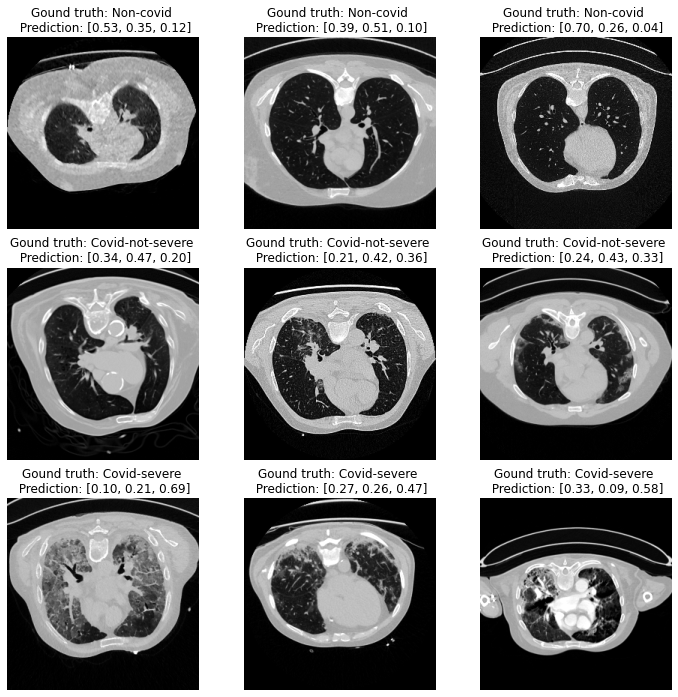

In [15]:
def get_img(idx):
    image = x_test[idx]
    label = y_test[idx]
    if label[0] == 1:
        tag = 'Non-covid'
    if label[1] == 1:
        tag = 'Covid-not-severe'
    if label[2] == 1:
        tag = 'Covid-severe'
    return image, tag

selected_case = [129, 130, 131, 125, 133, 136, 132, 135, 128]
plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image, tag = get_img(selected_case[i])
    plt.imshow(np.squeeze(image[:, :]), cmap="gray")
    prediction = model.predict(np.expand_dims(x_test[selected_case[i]], axis=0))[0]
    if i == 0 or i == 1 or i == 2:
        plt.title("Gound truth: Non-covid \n Prediction: [%.2f, %.2f, %.2f]" % (prediction[0], prediction[1], prediction[2]))
    if i == 3 or i == 4 or i == 5:
        plt.title("Gound truth: Covid-not-severe \n Prediction: [%.2f, %.2f, %.2f]" % (prediction[0], prediction[1], prediction[2]))
    if i == 6 or i == 7 or i == 8:
        plt.title("Gound truth: Covid-severe \n Prediction: [%.2f, %.2f, %.2f]" % (prediction[0], prediction[1], prediction[2]))
    plt.axis("off")